###  Keras Based Classifier (CNN)

### 1. Import Libraries

In [1]:
import os
import sys
import time
import shutil
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score


2025-10-07 18:11:31.561047: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-07 18:11:31.561294: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-07 18:11:31.602314: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-07 18:11:32.653258: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

## Enviroment setup 

In [2]:
import warnings
warnings.filterwarnings('ignore')

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Get the processing device
Check the availability of GPU


In [3]:
gpu_list = tf.config.list_physical_devices('GPU')

device = "gpu" if gpu_list !=[] else "cpu"
print(f"Device available for training: {device}")

Device available for training: cpu


2025-10-07 18:11:33.169200: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### 2. Data Loading and Preparation

In [4]:
# Define dataset path
dataset_path = os.path.join(os.getcwd(), "../data/images_dataSAT")
print(f"Dataset path: {dataset_path}")

model_name = os.path.join(os.getcwd(), "../models/cnn_model_keras_best.model.keras")

Dataset path: /home/ashmin/Projects/land-classification-using-deep-learning/notebooks/../data/images_dataSAT


### 3. Model Hyperparameters

In [ ]:
img_w, img_h = 64, 64
n_channels = 3
batch_size = 128
lr = 0.001 #
n_epochs = 30

steps_per_epoch = None
validation_steps = None 

### 4. Data Augmentation and Training and Validation Data Generator

In [6]:
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=40, 
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode="nearest",
                             validation_split=0.2
                            )

train_generator = datagen.flow_from_directory(dataset_path,
                    target_size = (img_w, img_h),
                    batch_size= batch_size,
                    class_mode="binary",
                    subset="training")

validation_generator = datagen.flow_from_directory(dataset_path, 
                        target_size = (img_w, img_h),
                        batch_size  = batch_size,
                        class_mode = "binary",
                        subset = "validation" )

Found 4800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


### 5. Model definition and compilation (CNN)

The model architecture is composed of several key components:
- **`Sequential`** is a linear stack of layers in Keras.
- **Conv2D** layers perform convolution operations, acting as feature detectors.
- **MaxPooling2D** reduces the spatial dimensions of the feature maps.
-  **BatchNormalization** normalizes layer inputs, stabilizing and accelerating training.
-  **GlobalAveragePooling2D** summarizes feature maps into a single vector, reducing parameters.
-  **Dense** (fully connected) layers learn complex patterns from these features.
-  **Dropout** is a regularization technique that randomly deactivates neurons during training.
-  **Sigmoid** activation is used for binary classification, mapping outputs to probabilities.
-  **HeUniform** initializer is suitable for ReLU activations.
-  **The final output `Dense` layer** uses a `sigmoid` activation for binary classification, outputting a probability between 0 and 1.

In [7]:
model = Sequential([
                    Conv2D(32 , (5,5) , activation="relu",padding="same",strides=(1,1), kernel_initializer=HeUniform(), input_shape=(img_w, img_h, n_channels)),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    Conv2D(64, (5,5) , activation="relu",padding="same" , strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    Conv2D(128, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    ###
                    Conv2D(256, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    Conv2D(512, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    Conv2D(1024, (5,5) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    
                    ###
                    GlobalAveragePooling2D(),
                    
                    Dense(64,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    Dense(128,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    Dense(256,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    ###
                    Dense(512,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    Dense(1024,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    Dense(2048,activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    
                    ###
                    Dense(1 , activation="sigmoid")
                    
                ])

### 6. Compiling the model and displaying the summary

In [8]:
loss = "binary_crossentropy"
model.compile(optimizer=Adam(learning_rate=lr),
              loss=loss, 
              metrics=["accuracy"])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 512)      │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 1024)     │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 1, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 20,352,897 (77.64 MB)

 Trainable params: 20,340,801 (77.59 MB)

 Non-trainable params: 12,096 (47.25 KB)

None


### 7. Checkpoint callback for model with **maximum accuracy**

In [9]:
checkpoint_cb = ModelCheckpoint(filepath=model_name,
                                monitor='val_accuracy',
                                mode='max',
                                save_best_only=True,
                                verbose=1
                               )

### 8. Model Training

In [10]:
print(f"Training on : ==={device}=== with batch size: {batch_size} & lr: {lr}")

fit = model.fit(train_generator, 
                epochs= n_epochs,
                steps_per_epoch = steps_per_epoch,
                validation_data=(validation_generator),
                validation_steps = validation_steps,
                callbacks=[checkpoint_cb],
                verbose=1
               )

Training on : ===cpu=== with batch size: 128 & lr: 0.001
Epoch 1/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7645 - loss: 0.5725
Epoch 1: val_accuracy improved from None to 0.51417, saving model to /home/ashmin/Projects/land-classification-using-deep-learning/notebooks/../models/cnn_model_keras_best.model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8679 - loss: 0.3861 - val_accuracy: 0.5142 - val_loss: 58.3959
Epoch 2/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9640 - loss: 0.1413
Epoch 2: val_accuracy did not improve from 0.51417
38/38 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9704 - loss: 0.1202 - val_accuracy: 0.4167 - val_loss: 15.1808
Epoch 3/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9749 - loss: 0.1066
Epoch 3: val_accuracy improved from 0.51417 to 0.52417, saving model to /home/ashmin/Projects/land-classification-using-deep-learning/notebooks/../models/cnn_model_keras_best.model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - ac

### 9. Model evaluation and visualization


In [11]:
steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))
batch_size = int(validation_generator.batch_size)

all_preds = []
all_labels = []
for step in range(steps):
    # Get one batch data
    images, labels = next(validation_generator)
    preds = model.predict(images)
    preds = (preds > 0.5).astype(int).flatten() 
    all_preds.extend(preds)
    all_labels.extend(labels)
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy Score: {accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Accuracy Score: 0.5308


### Visualizing the training history (accuracy and loss)

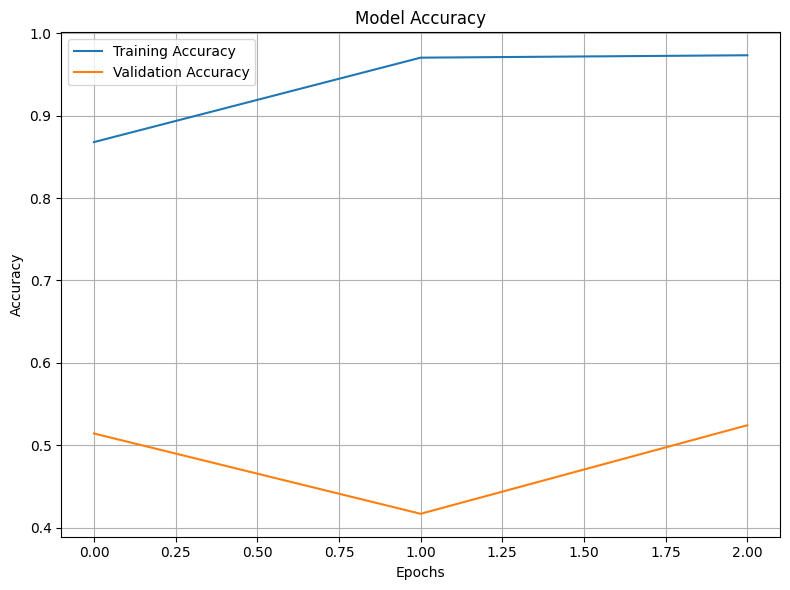

In [12]:
# Create a figure with a subplot
fig, axs = plt.subplots(figsize=(8, 6))

# Plot Accuracy on the first subplot
axs.plot(fit.history['accuracy'], label='Training Accuracy')
axs.plot(fit.history['val_accuracy'], label='Validation Accuracy')
axs.set_title('Model Accuracy')
axs.set_xlabel('Epochs')
axs.set_ylabel('Accuracy')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

### Visualizing the training loss and validation loss

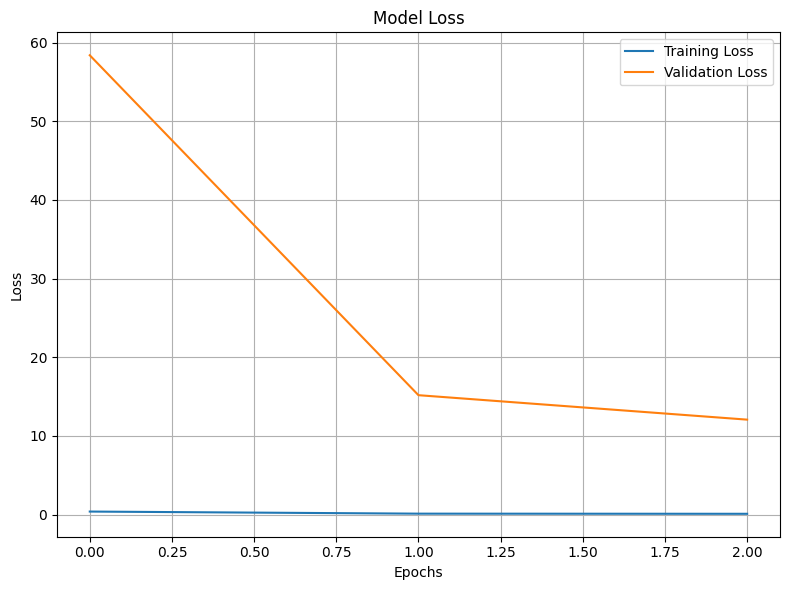

In [13]:
fig, axs = plt.subplots( figsize=(8, 6))


# Plot Loss on the second subplot
axs.plot(fit.history['loss'], label='Training Loss')
axs.plot(fit.history['val_loss'], label='Validation Loss')
axs.set_title('Model Loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()